In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from sklearn import decomposition
from sklearn import metrics
from sklearn import preprocessing

In [4]:
# METADATA 
DATASET = 0

In [5]:
def whiten_data(data):
    """
    Columns have zero mean and unit variance
    """
    return preprocessing.scale(data)

In [8]:
if DATASET == 0:
    testfile='../data/data_set_ALL_AML_independent.csv'
    trainfile='../data/data_set_ALL_AML_train.csv'
    patient_cancer='../data/actual.csv'
    
    # load csv
    train = pd.read_csv(trainfile)
    test = pd.read_csv(testfile)
    patient_cancer = pd.read_csv(patient_cancer)
    
    # filter columns
    train_keepers = [col for col in train.columns if "call" not in col]
    test_keepers = [col for col in test.columns if "call" not in col]
    train = train[train_keepers]
    test = test[test_keepers]
    
    # remove columns with text (Gene names)
    gene_description = train['Gene Description']
    gene_accession_number = train['Gene Accession Number']
    train = train.drop(['Gene Description','Gene Accession Number'],axis=1)
    test = test.drop(['Gene Description','Gene Accession Number'],axis=1)
    
    # transpose data to have each row represent a patient
    train = train.transpose()
    test = test.transpose()
    
    # zero mean and unit variance the data
    train = whiten_data(train)
    test = whiten_data(test)
    
    # initialize the labels for the data
    # patient cancer labels to 0 (ALL) and 1 (AML)
    patient_cancer = np.array(patient_cancer)
    patient_labels = []
    for p in patient_cancer:
        if p[1] == 'ALL':
            patient_labels.append(0)
        else:
            patient_labels.append(1)
    train_labels = patient_labels[0:len(train)]
    test_labels = patient_labels[len(train):]

### PCA Analysis

In [9]:
from sklearn.decomposition import PCA
NUM_COMPONENTS = 2
def _pca(data, num_comp):
    pca = PCA(n_components=num_comp)
    pca.fit(data)
    data_pca = pca.transform(data)
    return data_pca

In [10]:
# train
train_pca = _pca(train, NUM_COMPONENTS)
test_pca = _pca(test, NUM_COMPONENTS)

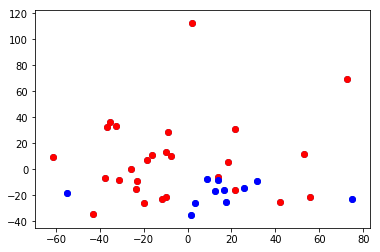

In [20]:
train_pca.shape
plt.scatter(train_pca[:,0], train_pca[:,1])
for i,p in enumerate(train_pca):
    if train_labels[i] == 0:
        plt.scatter(train_pca[i,0], train_pca[i,1], color='r', label='ALL')
    else:
        plt.scatter(train_pca[i,0], train_pca[i,1], color = 'b', label='AML')

plt.show()

### Naive Bayes Classifier

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
def _naive_bayes(ftrain, ftest):
    clf = GaussianNB()
    clf.fit(ftrain, train_labels)
    predicted = clf.predict(ftest)
    acc = accuracy_score(test_labels, predicted)
#     print(metrics.classification_report(test_labels, predicted))
    return acc

#### Accuracy VS Number of Components for Naive Bayes

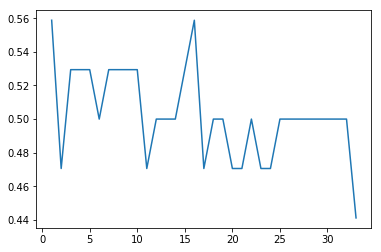

In [22]:
max_components = 33
accuracies = []
for i in range(max_components):
    nc = i + 1
    nc_pca_train = _pca(train, nc)
    nc_pca_test = _pca(test, nc)
    accuracies.append(_naive_bayes(nc_pca_train, nc_pca_test))
plt.plot([i+1 for i in range(max_components)], accuracies)
plt.show()
    

### SVM Classifier

In [33]:
from sklearn import svm
clf = svm.SVC()
# Try training on entire feature set
clf.fit(train, train_labels)
predicted = clf.predict(test)
print(metrics.classification_report(test_labels, predicted))

def _svm(ftrain, ftest):
    clf = svm.SVC()
    clf.fit(ftrain, train_labels)
    predicted = clf.predict(ftest)
    acc = accuracy_score(test_labels, predicted)
    return acc

             precision    recall  f1-score   support

          0       0.62      1.00      0.77        20
          1       1.00      0.14      0.25        14

avg / total       0.78      0.65      0.56        34



In [30]:
print predicted

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]


#### Accuracy VS Number of Components for SVM

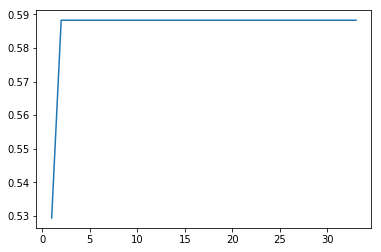

In [26]:
max_components = 33
accuracies = []
for i in range(max_components):
    nc = i + 1
    nc_pca_train = _pca(train, nc)
    nc_pca_test = _pca(test, nc)
    accuracies.append(_svm(nc_pca_train, nc_pca_test))
plt.plot([i+1 for i in range(max_components)], accuracies)
plt.show()


## F Score Feature Selection

In [112]:
import fscore_select_k as fsk

In [113]:
h, w = train.shape
fsk_mat = np.zeros((h, w+1))
fsk_mat[:,:w] = train
fsk_mat[:, w] = train_labels
k = 50

In [ ]:
fsk_output = fsk.GeneSelection(fsk_mat,50)
ordered_fscore_columns = [f[0] for f in fsk_output.gene_f_vals] # sorted list of f scores with the column they correspond to

In [ ]:
# Visualize for classifier X, how does accuracy vary with number of features selected (1 to k)
num_components = 30
fs_nb_accuracies = []
for i in range(num_components):
    nc = i + 1
    fs_train = train[:, ordered_fscore_columns[:nc]]
    fs_test = test[:, ordered_fscore_columns[:nc]]
    fs_nb_accuracies.append(_naive_bayes(fs_train, fs_test))
plt.plot([i+1 for i in range(num_components)], fs_nb_accuracies)
plt.show()

In [ ]:
num_components = 30
fs_svm_accuracies = []
for i in range(num_components):
    nc = i + 1
    fs_train = train[:, ordered_fscore_columns[:nc]]
    fs_test = test[:, ordered_fscore_columns[:nc]]
    fs_svm_accuracies.append(_svm(fs_train, fs_test))
plt.plot([i+1 for i in range(num_components)], fs_svm_accuracies)
plt.show()

## DPP Feature Selection

In [65]:
import sys
sys.path.append("./dpp")
import dpp

In [101]:
# sigmas = [0.0001, 0.1, 1, 2, 10]
sigmas = [1]
k = 1
train_cov = np.abs(np.cov(train.T))
gene_indices = [i for i in range(train.shape[1])]

### Train different classifiers on dpp features.

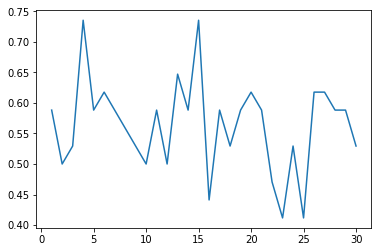

In [109]:
# Naive Bayes
dpp_nb_accuracies = []
num_components = 30
for i in range(num_components):
    nc = i+1
    selected_features = dpp.sample_k(gene_indices, train_cov, nc, max_nb_iterations=20000)  
    dpp_train = train[:, selected_features]
    dpp_test = test[:, selected_features]
    dpp_nb_accuracies.append(_naive_bayes(dpp_train, dpp_test))
plt.plot([i+1 for i in range(num_components)], dpp_nb_accuracies)
plt.show()


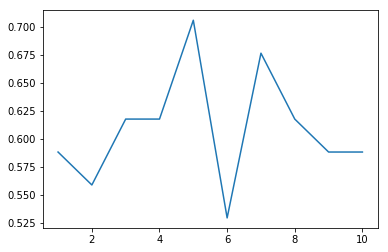

In [111]:
# SVM
dpp_svm_accuracies = []
num_components = 10
for i in range(num_components):
    nc = i+1
    selected_features = dpp.sample_k(gene_indices, train_cov, nc, max_nb_iterations=20000)  
    dpp_train = train[:, selected_features]
    dpp_test = test[:, selected_features]
    dpp_svm_accuracies.append(_svm(dpp_train, dpp_test))
plt.plot([i+1 for i in range(num_components)], dpp_svm_accuracies)
plt.show()